# CPU or GPU 

In [1]:
import tensorflow as tf
# # Configuración de TensorFlow para usar la GPU
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         print(e)

# # Configuración de TensorFlow para usar la CPU
tf.config.set_visible_devices([], 'GPU')

# LIBRARIES 

In [11]:
# Library EEG
import mne

# Library System 
import os
import numpy as np
from tqdm import tqdm
import time

# Library Statistics
import scipy.stats
import random
from scipy.stats import entropy
from scipy.fft import fft
from scipy.signal import welch
from scipy.stats import mstats

# Library EMOTION 
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization, Reshape, Conv2DTranspose, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.regularizers import l2

# Library Graph
import matplotlib.pyplot as plt
import seaborn as sns

# No Warning
import warnings
warnings.filterwarnings("ignore")
mne.set_log_level("ERROR")

In [3]:
os.getcwd()

'C:\\Users\\macka\\TFM_WD\\ORI\\SEEDs_FIF_RECOG_GAN'

# DATA

### Mapa 2D Canales.

In [4]:
# Electrode Position for assign label channel in plot.
electrode_positions= {
    "AF3": (6, 17),    "FP1":(8, 17),    "FPZ": (10, 17),    "FP2": (12, 17),    "AF4": (14, 17),
    "F7": (2, 15),    "F5": (4, 15),    "F3": (6, 15),    "F1": (8, 15),    "FZ": (10, 15),    "F2": (12, 15),    "F4": (14, 15),    "F6": (16, 15),    "F8": (18, 15), 
    "FT7": (2, 13),    "FC5": (4, 13),    "FC3": (6, 13),    "FC1": (8, 13),    "FCZ": (10, 13),    
    "FC2": (12, 13),    "FC4": (14, 13),    "FC6": (16, 13),    "FT8": (18, 13),   
    "T7": (2, 11),    "C5": (4, 11),    "C3": (6, 11),    "C1": (8, 11),    "CZ": (10, 11),    "C2": (12, 11),    "C4": (14, 11),    "C6": (16, 11),    "T8": (18, 11),  
    "TP7": (2, 9),    "CP5": (4, 9),    "CP3":(6, 9),    "CP1": (8, 9),    "CPZ": (10, 9),    "CP2": (12, 9),    "CP4": (14, 9),    "CP6": (16, 9),    "TP8": (18, 9),   
    "P7": (2, 7),    "P5":(4, 7),    "P3":(6, 7),    "P1":(8, 7),    "PZ":(10, 7),    "P2": (12, 7),    "P4": (14, 7),    "P6": (16, 7),    "P8": (18, 7),  
    "PO7": (4, 5),    "PO5":(6, 5),    "PO3": (8, 5),    "POZ":(10, 5),    "PO4": (12, 5),    "PO6": (14, 5),    "PO8": (16, 5),   
    "CB1": (6, 3),    "O1":(8, 3),    "OZ":(10, 3),    "O2":(12, 3),   
    "CB2": (14, 3),}

# Electrode Position for assign value channel.
electrode_positions_matrix= {
    "AF3": (2,5),    "FP1":(2,7),    "FPZ": (2,9),    "FP2": (2,11),    "AF4": (2,13),
    "F7": (4, 1),    "F5": (4, 3),    "F3": (4, 5),    "F1": (4, 7),    "FZ": (4, 9),    "F2": (4, 11),    "F4": (4, 13),    "F6": (4, 15),    "F8": (4, 17), 
    "FT7": (6, 1),    "FC5": (6, 3),    "FC3": (6, 5),    "FC1":(6, 7),    "FCZ": (6, 9),    
    "FC2": (6, 11),    "FC4": (6, 13),    "FC6": (6, 15),    "FT8": (6,17),   
    "T7": (8, 1),    "C5": (8, 3),    "C3": (8, 5),    "C1": (8, 7),    "CZ": (8, 9),"C2": (8, 11),    "C4": (8, 13),    "C6": (8, 15),    "T8": (8, 17), 
    "TP7": (10, 1), "CP5": (10, 3), "CP3": (10, 5), "CP1": (10, 7), "CPZ": (10, 9), "CP2": (10, 11), "CP4": (10, 13), "CP6": (10, 15), "TP8": (10, 17),
    "P7": (12, 1), "P5": (12, 3), "P3": (12, 5), "P1": (12, 7), "PZ": (12, 9), "P2": (12, 11), "P4": (12, 13), "P6": (12, 15), "P8": (12, 17),
    "PO7": (14, 3), "PO5": (14, 5), "PO3": (14, 7), "POZ": (14, 9), "PO4": (14, 11), "PO6": (14, 13), "PO8": (14, 15),   
    "CB1": (16, 5),    "O1":(16, 7),    "OZ":(16, 9),    "O2":(16, 11),   
    "CB2": (16, 13),}

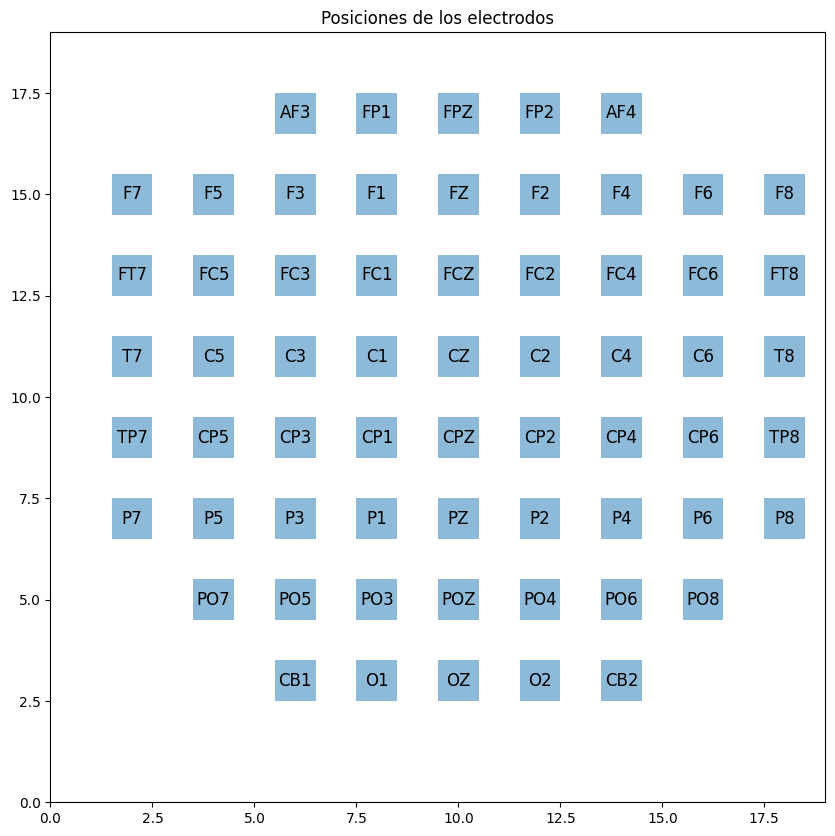

In [5]:
import matplotlib.pyplot as plt
h, w = 19, 19

# Creamos una figura
fig, ax = plt.subplots(figsize=(10, 10))

# Recorremos el diccionario de posiciones y añadimos un cuadrado y el nombre de cada electrodo en su posición reflejada
for electrode, position in electrode_positions.items():
    x,y = position
    ax.add_patch(plt.Rectangle((x - 0.5, y - 0.5), 1, 1, fill=True, alpha=0.5))
    ax.text(x, y, electrode, ha='center', va='center', fontsize=12)

# Configuramos el título, etiquetas de los ejes
ax.set_title('Posiciones de los electrodos')

ax.set_xlim([0, h])
ax.set_ylim([0, w])

# Mostramos la figura
plt.show()

## Constant to create segment

In [6]:
# Bands Frequencies: Names and ranges
freq_bands = {'delta': [0.5, 4],
              'theta': [4, 8],
              'alpha': [8, 12],
              'beta': [12, 30],
              'gamma': [30, 52]}


# Window Size to create object 4D
win_sec = 2

# Assuming a fixed height and width (19x19 in this case)
height, width = 19, 19

# Define the number of num_maps based on the number of EEG num_maps
num_maps = len(freq_bands) * 2 

# Define an map full zeros.
sparse_map = np.zeros((height, width))

### Segments Positives

In [7]:
start_time = time.time()  # Record the start time
# Ruta
emotion = 'POSITIVE'
emotion_folder = f'C://Users//macka//TFM_WD//ORI//SEEDs_FIF_RECOG_GAN//{emotion}'

archivos = os.listdir(emotion_folder)
names=[]
# imprime los nombres de los archivos
for archivo in archivos:
    if archivo.endswith(".fif"):
        names.append(archivo)
        
os.chdir(emotion_folder)

# Storage Data
psd_pos_data = {}

psd_pos_2d={}
de_pos_2d={}

segment_psd_pos={}
segment_de_pos={}

segment_pos=[]
segment_pos_list=[]

input_data_pos = []

def gaussian_entropy(std_deviation):
    """
    Calcular la entropía diferencial para una distribución gaussiana.
    :param std_deviation: desviación estándar de la señal.
    :return: entropía diferencial.
    """
    return 0.5 * np.log2(2 * np.pi * np.e * std_deviation ** 2)

# Cargar el Archivo
for name in tqdm(names,desc="Procesing new file...", leave=False):
    # Definir la ruta del archivo EEG
    file = name
    file_path = os.path.join(emotion_folder, file)

    # Cargar los datos EEG
    eeg_data = mne.io.read_raw_fif(file_path, preload=True)
    # Definir la frecuencia de muestreo
    sfreq = eeg_data.info['sfreq']

    # Definir Caracteristicas de la VENTANA (4 segundos)
    win_samples = int(win_sec * sfreq)
    total_windows = int(np.floor(len(eeg_data.times) / win_samples))
       
    # Creación Ventana
    # Recorrer cada ventana y aplicar el filtro pasa banda a los datos de EEG para cada banda de frecuencia
    for i in range(total_windows): # 1=total_windows
        
        # Obtener los datos de EEG para la ventana actual
        start_idx = i * win_samples
        stop_idx = (i + 1) * win_samples
        data_descompose = eeg_data.copy().crop(tmin=start_idx / sfreq, tmax=stop_idx / sfreq)
        channel_names=data_descompose.ch_names
        
        # Crea Las Bandas de Frecuencia para CADA VENTANA
        # Aplicar un filtro pasa banda a los datos de EEG para cada banda de frecuencia
        for band_name, (low_freq, high_freq) in freq_bands.items():
            filtered_data = data_descompose.copy().filter(l_freq=low_freq, h_freq=high_freq)
        
            # Calcular la PSD usando la función 'psd_welch' de MNE
            psd, freqs = mne.time_frequency.psd_array_welch(filtered_data.get_data(), sfreq, fmin=low_freq, fmax=high_freq, n_fft=int(sfreq), n_overlap=int(sfreq / 2))
            psd_pos_data[band_name] = psd
   
            for key, value in psd_pos_data.items():
                segment_psd_pos[key] = [sum(sublist)/len(sublist) for sublist in value]

            # Calcular la entropía diferencial para cada canal en la banda de frecuencia actual
            data_array = filtered_data.get_data()
            for i in range(data_array.shape[0]):
                std_deviation = np.std(filtered_data[i, :])
                de = np.squeeze(gaussian_entropy(std_deviation))
                de = np.nan_to_num(de,posinf=0.0)
                de=np.mean(de)
                
                if band_name not in segment_de_pos:
                    segment_de_pos[band_name] = [de]  # crea un nuevo array con el primer valor de 'de'
                else:
                    segment_de_pos[band_name].append(de)  # agrega el valor de 'de' al final del array existente
        # Matriz 2D PSD           
        for band_name, values in segment_psd_pos.items():
            for i, channel_name in enumerate(channel_names):
                x, y = electrode_positions_matrix[channel_name]
                sparse_map[y, x] = values[i]
                
            psd_pos_2d[band_name]=sparse_map
        # Matriz 2D DE    
        for band_name, values in segment_de_pos.items():
            for i, channel_name in enumerate(channel_names):
                x, y = electrode_positions_matrix[channel_name]
                sparse_map[y, x] = values[i]
                
            de_pos_2d[band_name]=sparse_map
        
        # Creación Segmentos
        segment_pos.append([de_pos_2d,psd_pos_2d])
        segment_pos_list.append(segment_pos)
        
elapsed_time = time.time() - start_time
hour=elapsed_time/3600
print(f"Time: {hour:.2f} H")

Time: 3.20 H


#### Create Input 4D - (nºsegments,height,width,channels)

In [24]:
start_time = time.time()  # Record the start time

# Calculate the number of samples (batch size) from the processed segments
num_segment = len(segment_pos_list)

# Initialize the 4D input with zeros
input_4d_pos = np.zeros((num_segment, height, width, num_maps))

for i, segment in tqdm(enumerate(segment_pos_list), desc="Creating 4D...", leave=False):
    for feature_type_idx, feature_data in enumerate(segment[0]):  # Agregar [0] aquí
        current_feature_data = segment[0][feature_type_idx]
        for channel_idx, channel_name in enumerate(electrode_positions):
            for band_idx, band_name in enumerate(freq_bands.keys()):
                x, y = electrode_positions_matrix[channel_name]
                 # Aplanar los datos
                current_feature_data_flat = current_feature_data[band_name].flatten()

                # Aplicar Winsorizing
                current_feature_data_winsorized = mstats.winsorize(current_feature_data_flat, limits=[0.01, 0.01])

                # Remodelar los datos a la forma original
                current_feature_data_winsorized = current_feature_data_winsorized.reshape(current_feature_data[band_name].shape)

                # Asignar los datos winsorizados a la matriz de entrada
                input_4d_pos[i, y, x, band_idx + feature_type_idx * len(freq_bands)] = current_feature_data_winsorized[y, x]
                
print(f"4D input shape: {input_4d_pos.shape}")

elapsed_time = time.time() - start_time
hour=elapsed_time/3600
print(f"Time: {hour:.2f} H")


4D input shape: (51648, 19, 19, 10)
Time: 0.38 H


### Segments Neutral

In [8]:
start_time = time.time()  # Record the start time
# Ruta
emotion = 'NEUTRAL'
emotion_folder = f'C://Users//macka//TFM_WD//ORI//SEEDs_FIF_RECOG_GAN//{emotion}'

archivos = os.listdir(emotion_folder)
names=[]
# imprime los nombres de los archivos
for archivo in archivos:
    if archivo.endswith(".fif"):
        names.append(archivo)
        
os.chdir(emotion_folder)

# Data Storage
psd_neu_data = {}

psd_neu_2d={}
de_neu_2d={}

segment_psd_neu={}
segment_de_neu={}

segment_neu=[]
segment_neu_list=[]

input_data_neu=[]

def gaussian_entropy(std_deviation):
    """
    Calcular la entropía diferencial para una distribución gaussiana.
    :param std_deviation: desviación estándar de la señal.
    :return: entropía diferencial.
    """
    return 0.5 * np.log2(2 * np.pi * np.e * std_deviation ** 2)

# Cargar el Archivo
for name in tqdm(names,desc="Procesing new file...", leave=False):
    # Definir la ruta del archivo EEG
    file = name
    file_path = os.path.join(emotion_folder, file)

    # Cargar los datos EEG
    eeg_data = mne.io.read_raw_fif(file_path, preload=True)
    # Definir la frecuencia de muestreo
    sfreq = eeg_data.info['sfreq']

    # Definir Caracteristicas de la VENTANA (4 segundos)
    win_samples = int(win_sec * sfreq)
    total_windows = int(np.floor(len(eeg_data.times) / win_samples))
      
    # Creación Ventana
    # Recorrer cada ventana y aplicar el filtro pasa banda a los datos de EEG para cada banda de frecuencia
    for i in range(total_windows): # 1=total_windows
        
        # Obtener los datos de EEG para la ventana actual
        start_idx = i * win_samples
        stop_idx = (i + 1) * win_samples
        data_descompose = eeg_data.copy().crop(tmin=start_idx / sfreq, tmax=stop_idx / sfreq)
        channel_names=data_descompose.ch_names
        
        # Crea Las Bandas de Frecuencia para CADA VENTANA
        # Aplicar un filtro pasa banda a los datos de EEG para cada banda de frecuencia
        for band_name, (low_freq, high_freq) in freq_bands.items():
            filtered_data = data_descompose.copy().filter(l_freq=low_freq, h_freq=high_freq)
        
            # Calcular la PSD usando la función 'psd_welch' de MNE
            psd, freqs = mne.time_frequency.psd_array_welch(filtered_data.get_data(), sfreq, fmin=low_freq, fmax=high_freq, n_fft=int(sfreq), n_overlap=int(sfreq / 2))
            psd_neu_data[band_name] = psd
   
            for key, value in psd_neu_data.items():
                segment_psd_neu[key] = [sum(sublist)/len(sublist) for sublist in value]

            # Calcular la entropía diferencial para cada canal en la banda de frecuencia actual
            data_array = filtered_data.get_data()
            for i in range(data_array.shape[0]):
                std_deviation = np.std(filtered_data[i, :])
                de = np.squeeze(gaussian_entropy(std_deviation))
                de = np.nan_to_num(de,posinf=0.0)
                de=np.mean(de)
                
                if band_name not in segment_de_neu:
                    segment_de_neu[band_name] = [de]  # crea un nuevo array con el primer valor de 'de'
                else:
                    segment_de_neu[band_name].append(de)  # agrega el valor de 'de' al final del array existente
        # Matriz 2D PSD           
        for band_name, values in segment_psd_neu.items():
            for i, channel_name in enumerate(channel_names):
                x, y = electrode_positions_matrix[channel_name]
                sparse_map[y, x] = values[i]
                
            psd_neu_2d[band_name]=sparse_map
        # Matriz 2D DE    
        for band_name, values in segment_de_neu.items():
            for i, channel_name in enumerate(channel_names):
                x, y = electrode_positions_matrix[channel_name]
                sparse_map[y, x] = values[i]
                
            de_neu_2d[band_name]=sparse_map
        
        # Creación Segmentos
        segment_neu.append([de_neu_2d,psd_neu_2d])
        segment_neu_list.append(segment_neu)

elapsed_time = time.time() - start_time
hour=elapsed_time/3600
print(f"Time: {hour:.2f} H")

Time: 2.40 H


#### Create Input 4D - (nºsegments,height,width,channels)

In [25]:
start_time = time.time()  # Record the start time
# Calculate the number of samples (batch size) from the processed segments
num_segment = len(segment_neu_list)

# Initialize the 4D input with zeros
input_4d_neu = np.zeros((num_segment, height, width, num_maps))

for i, segment in tqdm(enumerate(segment_neu_list), desc="Creating 4D...", leave=False):
    for feature_type_idx, feature_data in enumerate(segment[0]):  # Agregar [0] aquí
        current_feature_data = segment[0][feature_type_idx]
        for channel_idx, channel_name in enumerate(electrode_positions):
            for band_idx, band_name in enumerate(freq_bands.keys()):
                x, y = electrode_positions_matrix[channel_name]
                 # Aplanar los datos
                current_feature_data_flat = current_feature_data[band_name].flatten()

                # Aplicar Winsorizing
                current_feature_data_winsorized = mstats.winsorize(current_feature_data_flat, limits=[0.01, 0.01])

                # Remodelar los datos a la forma original
                current_feature_data_winsorized = current_feature_data_winsorized.reshape(current_feature_data[band_name].shape)

                # Asignar los datos winsorizados a la matriz de entrada
                input_4d_neu[i, y, x, band_idx + feature_type_idx * len(freq_bands)] = current_feature_data_winsorized[y, x]
print(f"4D input shape: {input_4d_neu.shape}")

elapsed_time = time.time() - start_time
hour=elapsed_time/3600
print(f"Time: {hour:.2f} H")

4D input shape: (55376, 19, 19, 10)
Time: 0.39 H


### Segments Negatives

In [9]:
start_time = time.time()  # Rec ord the start time
# Ruta
emotion ='NEGATIVE'
emotion_folder = f'C://Users//macka//TFM_WD//ORI//SEEDs_FIF_RECOG_GAN//{emotion}'

archivos = os.listdir(emotion_folder)
names=[]
# imprime los nombres de los archivos
for archivo in archivos:
    if archivo.endswith(".fif"):
        names.append(archivo)
        
os.chdir(emotion_folder)

#Data Storage
psd_neg_data = {}

psd_neg_2d={}
de_neg_2d={}

segment_psd_neg={}
segment_de_neg={}

psd_list=[]
de_list=[]

segment_neg=[]
segment_neg_list=[]

input_data_neg=[]

def gaussian_entropy(std_deviation):
    """
    Calcular la entropía diferencial para una distribución gaussiana.
    :param std_deviation: desviación estándar de la señal.
    :return: entropía diferencial.
    """
    return 0.5 * np.log2(2 * np.pi * np.e * std_deviation ** 2)

# Cargar el Archivo
for name in tqdm(names,desc="Procesing new file...", leave=False):
    # Definir la ruta del archivo EEG
    file = name
    file_path = os.path.join(emotion_folder, file)

    # Cargar los datos EEG
    eeg_data = mne.io.read_raw_fif(file_path, preload=True)
    # Definir la frecuencia de muestreo
    sfreq = eeg_data.info['sfreq']

    # Definir Caracteristicas de la VENTANA (4 segundos)
    win_samples = int(win_sec * sfreq)
    total_windows = int(np.floor(len(eeg_data.times) / win_samples))
         
    # Creación Ventana
    # Recorrer cada ventana y aplicar el filtro pasa banda a los datos de EEG para cada banda de frecuencia
    for i in range(total_windows): # 1=total_windows
        
        # Obtener los datos de EEG para la ventana actual
        start_idx = i * win_samples
        stop_idx = (i + 1) * win_samples
        data_descompose = eeg_data.copy().crop(tmin=start_idx / sfreq, tmax=stop_idx / sfreq)
        channel_names=data_descompose.ch_names
        
        # Crea Las Bandas de Frecuencia para CADA VENTANA
        # Aplicar un filtro pasa banda a los datos de EEG para cada banda de frecuencia
        for band_name, (low_freq, high_freq) in freq_bands.items():
            filtered_data = data_descompose.copy().filter(l_freq=low_freq, h_freq=high_freq)
        
            # Calcular la Power Spectral Density usando la función 'psd_welch' de MNE
            psd, freqs = mne.time_frequency.psd_array_welch(filtered_data.get_data(), sfreq, fmin=low_freq, fmax=high_freq, n_fft=int(sfreq), n_overlap=int(sfreq / 2))
            psd_neg_data[band_name] = psd
   
            for key, value in psd_neg_data.items():
                segment_psd_neg[key] = [sum(sublist)/len(sublist) for sublist in value]

            # Calcular la entropía diferencial para cada canal en la banda de frecuencia actual
            data_array = filtered_data.get_data()
            for i in range(data_array.shape[0]):
                std_deviation = np.std(filtered_data[i, :])
                de = np.squeeze(gaussian_entropy(std_deviation))
                de = np.nan_to_num(de,posinf=0.0)
                de=np.mean(de)
                
                if band_name not in segment_de_neg:
                    segment_de_neg[band_name] = [de]  # crea un nuevo array con el primer valor de 'de'
                else:
                    segment_de_neg[band_name].append(de)  # agrega el valor de 'de' al final del array existente
                    
        # Matriz 2D PSD           
        for band_name, values in segment_psd_neg.items():
            for i, channel_name in enumerate(channel_names):
                x, y = electrode_positions_matrix[channel_name]
                sparse_map[y, x] = values[i]
                
            psd_neg_2d[band_name]=sparse_map
        # Matriz 2D DE    
        for band_name, values in segment_de_neg.items():
            for i, channel_name in enumerate(channel_names):
                x, y = electrode_positions_matrix[channel_name]
                sparse_map[y, x] = values[i]
                
            de_neg_2d[band_name]=sparse_map
        
        # Creación Segmentos
        segment_neg.append([de_neg_2d,psd_neg_2d])
        segment_neg_list.append(segment_neg)
        
elapsed_time = time.time() - start_time
hour=elapsed_time/3600
print(f"Time: {hour:.2f} H")

Time: 2.84 H


#### Create Input 4D - (nºsegments,height,width,channels)

In [26]:
start_time = time.time()  # Record the start time

# Calculate the number of samples (batch size) from the processed segments
num_segment = len(segment_neg_list)

# Define the number of num_maps based on the number of EEG num_maps
num_maps = len(freq_bands) * 2 

# Initialize the 4D input with zeros
input_4d_neg = np.zeros((num_segment, height, width, num_maps))

for i, segment in tqdm(enumerate(segment_neg_list), desc="Creating 4D...", leave=False):
    for feature_type_idx, feature_data in enumerate(segment[0]):  # Agregar [0] aquí
        current_feature_data = segment[0][feature_type_idx]
        for channel_idx, channel_name in enumerate(electrode_positions):
            for band_idx, band_name in enumerate(freq_bands.keys()):
                x, y = electrode_positions_matrix[channel_name]
 # Aplanar los datos
                current_feature_data_flat = current_feature_data[band_name].flatten()

                # Aplicar Winsorizing
                current_feature_data_winsorized = mstats.winsorize(current_feature_data_flat, limits=[0.01, 0.01])

                # Remodelar los datos a la forma original
                current_feature_data_winsorized = current_feature_data_winsorized.reshape(current_feature_data[band_name].shape)

                # Asignar los datos winsorizados a la matriz de entrada
                input_4d_neg[i, y, x, band_idx + feature_type_idx * len(freq_bands)] = current_feature_data_winsorized[y, x]
print(f"4D input shape: {input_4d_neg.shape}")

elapsed_time = time.time() - start_time
hour=elapsed_time/3600
print(f"Time: {hour:.2f} H")

4D input shape: (62288, 19, 19, 10)
Time: 0.44 H


# Reconocimiento de emociones

In [27]:
# Concatenate the 4D inputs for each emotion
X = np.concatenate([input_4d_pos, input_4d_neu, input_4d_neg], axis=0)
X_standardized = (X - X.mean()) / X.std()

# Create labels for each emotion
# # Assuming the labels are 2 for positive, 1 for neutral, and 0 for negative
y_positive = np.full((input_4d_pos.shape[0],), 1, dtype=int)
y_neutral = np.full((input_4d_neu.shape[0],), 0, dtype=int)
y_negative = np.full((input_4d_neg.shape[0],), -1, dtype=int)

# Concatenate the labels
y = np.concatenate([y_positive,y_neutral, y_negative], axis=0) 

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state= 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.11, random_state=42)

print(f'X (train/test/val):{len(X_train)},{len(X_test)},{len(X_val)} -- y (train/test/val):{len(y_train)},{len(y_test)},{len(y_val)}')

X (train/test/val):135618,16932,16762 -- y (train/test/val):135618,16932,16762


### Model 1 

In [28]:
def build_CNN_model1(input_shape, num_classes):
        

    model1 = Sequential()

    model1.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape, kernel_regularizer=l2(l2_reg)))
    model1.add(BatchNormalization())
    model1.add(MaxPooling2D((2, 2)))
    model1.add(Dropout(0.25))

    model1.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_reg)))
    model1.add(BatchNormalization())
    model1.add(MaxPooling2D((2, 2)))
    model1.add(Dropout(0.25))

    model1.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_reg)))
    model1.add(BatchNormalization())
    model1.add(MaxPooling2D((2, 2)))
    model1.add(Dropout(0.25))

    model1.add(Flatten())

    model1.add(Dense(512, activation='relu', kernel_regularizer=l2(l2_reg)))
    model1.add(BatchNormalization())
    model1.add(Dropout(0.5))

    model1.add(Dense(1024, activation='relu', kernel_regularizer=l2(l2_reg)))
    model1.add(BatchNormalization())
    model1.add(Dropout(0.5))

    model1.add(Dense(num_classes, activation='softmax'))

    model1.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
        
    return model1

l2_reg = 0.001
input_shape = X_train.shape[1:]
num_classes = 3

model1 = build_CNN_model1(input_shape, num_classes)

start_time = time.time()

In [32]:
epochs = 20
batch_size = 32

y_train_onehot = to_categorical(y_train, num_classes=3)
y_test_onehot = to_categorical(y_test, num_classes=3)
y_val_onehot = to_categorical(y_val, num_classes=3)
history = model1.fit(X_train, y_train_onehot, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val_onehot))

elapsed_time = time.time() - start_time
hour=elapsed_time/3600
print(f"Time: {hour:.2f} H")

Epoch 1/20
4239/4239 [==============================] - 71s 17ms/step - loss: 1.1069 - accuracy: 0.3616 - val_loss: 1.1105 - val_accuracy: 0.3674
Epoch 2/20
4239/4239 [==============================] - 76s 18ms/step - loss: 1.1085 - accuracy: 0.3619 - val_loss: 1.1045 - val_accuracy: 0.3674
Epoch 3/20
4239/4239 [==============================] - 78s 18ms/step - loss: 1.1075 - accuracy: 0.3627 - val_loss: 1.1038 - val_accuracy: 0.3674
Epoch 4/20
4239/4239 [==============================] - 76s 18ms/step - loss: 1.1080 - accuracy: 0.3605 - val_loss: 1.1113 - val_accuracy: 0.3674
Epoch 5/20
4239/4239 [==============================] - 75s 18ms/step - loss: 1.1068 - accuracy: 0.3626 - val_loss: 1.1086 - val_accuracy: 0.3674
Epoch 6/20
4239/4239 [==============================] - 75s 18ms/step - loss: 1.1086 - accuracy: 0.3619 - val_loss: 1.1066 - val_accuracy: 0.3674
Epoch 7/20
4239/4239 [==============================] - 75s 18ms/step - loss: 1.1077 - accuracy: 0.3611 - val_loss: 1.1053 -

In [33]:
accuracy_train = model1.history.history['accuracy'][-1]
loss0, accuracy_test = model1.evaluate(X_test, y_test_onehot)

print(f'ACC. TEST: {accuracy_test} -- ACC. TRAIN: {accuracy_train} ')

530/530 [==============================] - 3s 6ms/step - loss: 1.0998 - accuracy: 0.3725
ACC. TEST: 0.37248995900154114 -- ACC. TRAIN: 0.36254775524139404 


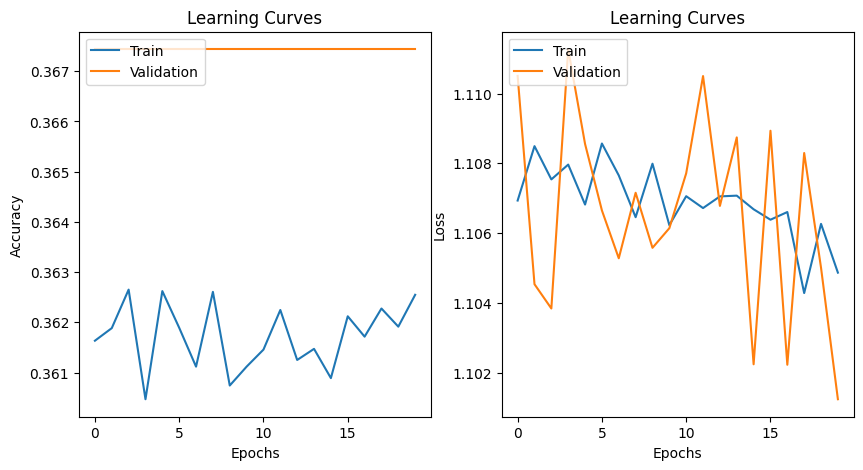

In [34]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# To visualize the accuracy of training and validation over time
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('Learning Curves')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].legend(['Train', 'Validation'], loc='upper left')


# Visualize the loss of training and validation over time
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Learning Curves')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epochs')
axs[1].legend(['Train', 'Validation'], loc='upper left')
fig.show()